In [1]:
import pandas

import seaborn
from matplotlib import pyplot
from IPython.display import Image, display

from pathlib import Path

import json

In [2]:
FILTERED_REAL_SET = 91123
FILTERING_WORKFLOW = 17313 
DATA_LOCATION = Path('../../superwasp-data/')

## Merge subject metadata with CNN scores

In [3]:
zoo_subjects_cache = DATA_LOCATION / 'junk-filtering-cnn-subjects.pkl'
if zoo_subjects_cache.exists():
    zoo_subjects = pandas.read_pickle(zoo_subjects_cache)
else:
    zoo_lookup = pandas.read_csv(
        DATA_LOCATION / 'lookup.dat',
        delim_whitespace=True,
        header=None,
    )
    zoo_lookup.columns = [
        'subject_id',
        'SWASP ID',
        'Period',
        'Period Number',
    ]
    zoo_subjects = pandas.read_csv(
        DATA_LOCATION / 'superwasp-variable-stars-subjects.csv',
    )
    zoo_subjects = zoo_subjects[['subject_id', 'subject_set_id', 'workflow_id', 'retired_at', 'locations']]
    zoo_subjects = zoo_subjects.merge(zoo_lookup)
    zoo_subjects['file'] = zoo_subjects.apply(lambda r: f"{r['SWASP ID']}_P{r['Period Number']}_fold.gif", axis=1)
    zoo_subjects['locations'] = zoo_subjects.apply(lambda r: list(json.loads(r['locations']).values())[0], axis=1)
    zoo_subjects['retired_at'] = pandas.to_datetime(zoo_subjects['retired_at'])
    zoo_subjects.rename({'locations': 'location'}, axis=1, inplace=True)
    zoo_subjects.to_pickle(zoo_subjects_cache)
zoo_subjects

,subject_id,subject_set_id,workflow_id,retired_at,location,SWASP ID,Period,Period Number,file
0,21803097,25294,NaN,NaT,https://panoptes-uploads.zooniverse.org/subjec...,1SWASPJ235711.82+203913.7,1039108.812,1,1SWASPJ235711.82+203913.7_P1_fold.gif
1,21803099,25294,NaN,NaT,https://panoptes-uploads.zooniverse.org/subjec...,1SWASPJ235711.86-443012.2,8565206.000,1,1SWASPJ235711.86-443012.2_P1_fold.gif
2,21803099,99480,17313.0,2022-03-03 18:29:16+00:00,https://panoptes-uploads.zooniverse.org/subjec...,1SWASPJ235711.86-443012.2,8565206.000,1,1SWASPJ235711.86-443012.2_P1_fold.gif
3,21803102,25294,NaN,NaT,https://panoptes-uploads.zooniverse.org/subjec...,1SWASPJ235712.73+560850.9,427987.000,1,1SWASPJ235712.73+560850.9_P1_fold.gif
4,21803103,25294,NaN,NaT,https://panoptes-uploads.zooniverse.org/subjec...,1SWASPJ235712.73+560850.9,325253.969,3,1SWASPJ235712.73+560850.9_P3_fold.gif
...,...,...,...,...,...,...,...,...,...
3413055,27472158,61241,NaN,NaT,https://panoptes-uploads.zooniverse.org/subjec...,1SWASPJ235711.12+554414.6,275688.125,1,1SWASPJ235711.12+554414.6_P1_fold.gif
3413056,27472159,61241,NaN,NaT,https://panoptes-uploads.zooniverse.org/subjec...,1SWASPJ235711.21-644054.6,9000393.000,1,1SWASPJ235711.21-644054.6_P1_fold.gif
3413057,27472159,99480,17313.0,2022-04-06 11:58:06+00:00,https://panoptes-uploads.zooniverse.org/subjec...,1SWASPJ235711.21-644054.6,9000393.000,1,1SWASPJ235711.21-644054.6_P1_fold.gif
3413058,27472160,61241,NaN,NaT,https://panoptes-uploads.zooniverse.org/subjec...,1SWASPJ235711.22-644053.9,9002109.000,1,1SWASPJ235711.22-644053.9_P1_fold.gif


In [4]:
filtered_real_subjects = zoo_subjects[zoo_subjects['subject_set_id'] == FILTERED_REAL_SET]
zoo_subjects = zoo_subjects[(zoo_subjects['workflow_id'] == FILTERING_WORKFLOW) & zoo_subjects['retired_at'].notna()]

In [5]:
cnn_scores = pandas.read_csv(DATA_LOCATION / 'svs-junk-predictions.csv', header=0, names=['file', 'prediction'])
cnn_scores = cnn_scores.merge(zoo_subjects)
cnn_scores['zoo_classification_real'] = cnn_scores['subject_id'].isin(filtered_real_subjects['subject_id'])
cnn_scores = cnn_scores[['file', 'subject_id', 'prediction', 'zoo_classification_real', 'location']]

## Plot distribution of scores vs human classifications

<AxesSubplot:xlabel='zoo_classification_real', ylabel='prediction'>

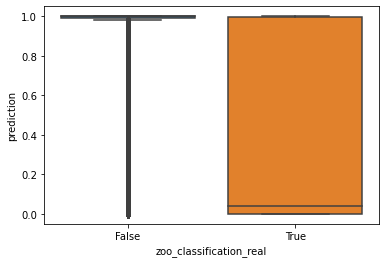

In [6]:
seaborn.boxplot(data=cnn_scores, x='zoo_classification_real', y='prediction')

<AxesSubplot:ylabel='Frequency'>

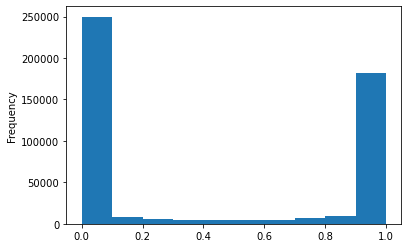

In [7]:
cnn_scores[cnn_scores['zoo_classification_real']]['prediction'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

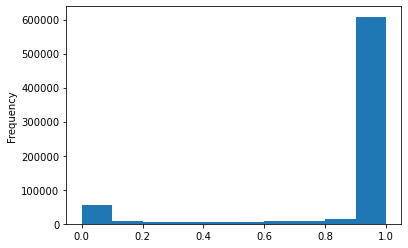

In [8]:
cnn_scores[~cnn_scores['zoo_classification_real']]['prediction'].plot.hist()

## Count classifications

In [42]:
zoo_classifications_cache = DATA_LOCATION / 'junk-filtering-cnn-classifications.pkl'
if zoo_classifications_cache.exists():
    zoo_classifications = pandas.read_pickle(zoo_classifications_cache)
else:
    zoo_classifications = pandas.read_csv(
        DATA_LOCATION / 'superwasp-variable-stars-classifications.csv',
    )
    zoo_classifications = zoo_classifications[zoo_classifications['workflow_id'] == FILTERING_WORKFLOW]
    zoo_classifications.rename({'subject_ids': 'subject_id'}, axis=1, inplace=True)
    zoo_classifications['created_at'] = pandas.to_datetime(zoo_classifications['created_at'])
    zoo_classifications.to_pickle(zoo_classifications_cache)
zoo_classifications.drop_duplicates(subset=['user_name', 'subject_id'], inplace=True)
zoo_classifications = zoo_classifications.merge(zoo_subjects[['subject_id', 'retired_at']]).drop_duplicates()
zoo_classifications = zoo_classifications[zoo_classifications['created_at'] <= zoo_classifications['retired_at']]
zoo_classifications

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_id,retired_at
0,300129666,astopy,10.0,b0278f65e4c54553a5ee,17313,Real or junk?,5.12,2021-01-08 15:03:41+00:00,NaN,NaN,"{""source"":""api"",""session"":""4b5661ac01d7a644ca2...","[{""task"":""T0"",""task_label"":""Is this real or ju...","{""24621040"":{""retired"":{""id"":76114927,""workflo...",24621040,2021-01-08 15:03:42+00:00
1,300129701,astopy,10.0,b0278f65e4c54553a5ee,17313,Real or junk?,5.12,2021-01-08 15:03:46+00:00,NaN,NaN,"{""source"":""api"",""session"":""4b5661ac01d7a644ca2...","[{""task"":""T0"",""task_label"":""Is this real or ju...","{""24585306"":{""retired"":{""id"":76114928,""workflo...",24585306,2021-03-16 23:29:46+00:00
3,300198253,gallucci2789,2132898.0,475ce8d890b21b12033c,17313,Real or junk?,5.12,2021-01-08 18:51:28+00:00,NaN,NaN,"{""session"":""3781d35bbf8e75385c7de5cd1ca160a3ab...","[{""task"":""T0"",""task_label"":""Is this real or ju...","{""24585306"":{""retired"":{""id"":76114928,""workflo...",24585306,2021-03-16 23:29:46+00:00
5,317449370,Ycanopalacios,2135368.0,e8ef16cbffa934b30794,17313,Real or junk?,5.12,2021-03-16 23:29:46+00:00,NaN,NaN,"{""source"":""api"",""session"":""fa932041046eabc8c49...","[{""task"":""T0"",""task_label"":""Is this real or ju...","{""24585306"":{""retired"":{""id"":76114928,""workflo...",24585306,2021-03-16 23:29:46+00:00
7,300130315,astopy,10.0,5f1012f448614e8f4ba3,17313,Real or junk?,5.12,2021-01-08 15:05:59+00:00,NaN,NaN,"{""session"":""c45a7f58838e4ba41be5d0bb92ae95e496...","[{""task"":""T0"",""task_label"":""Is this real or ju...","{""24631107"":{""retired"":{""id"":76115515,""workflo...",24631107,2021-01-08 15:06:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952797,546050008,gatoreasy1,1810454.0,e8ef16cbffa934b30794,17313,Real or junk?,5.12,2024-03-07 04:12:18+00:00,NaN,NaN,"{""source"":""api"",""session"":""9fdb5f30533d7e97425...","[{""task"":""T0"",""task_label"":""Is this real or ju...","{""23318616"":{""retired"":{""id"":125180919,""workfl...",23318616,2024-03-07 04:12:20+00:00
2952798,546050067,gatoreasy1,1810454.0,e8ef16cbffa934b30794,17313,Real or junk?,5.12,2024-03-07 04:12:45+00:00,NaN,NaN,"{""source"":""api"",""session"":""9fdb5f30533d7e97425...","[{""task"":""T0"",""task_label"":""Is this real or ju...","{""22480864"":{""retired"":{""id"":125353949,""workfl...",22480864,2024-03-07 04:12:46+00:00
2952799,546096493,danie_identifies,2710910.0,99489dd7c79eab61d267,17313,Real or junk?,5.12,2024-03-07 13:43:53+00:00,NaN,NaN,"{""session"":""12a51cc75a24358363f006477845a0d22b...","[{""task"":""T0"",""task_label"":""Is this real or ju...","{""24545919"":{""retired"":{""id"":125369072,""workfl...",24545919,2024-03-07 13:43:55+00:00
2952800,546096785,danie_identifies,2710910.0,99489dd7c79eab61d267,17313,Real or junk?,5.12,2024-03-07 13:45:47+00:00,NaN,NaN,"{""session"":""12a51cc75a24358363f006477845a0d22b...","[{""task"":""T0"",""task_label"":""Is this real or ju...","{""24561967"":{""retired"":{""id"":125372427,""workfl...",24561967,2024-03-07 13:45:48+00:00


In [43]:
classification_counts = pandas.pivot_table(
    zoo_classifications,
    values='classification_id',
    aggfunc=len,
    index='subject_id',
)
classification_counts.rename({'classification_id': 'classification_count'}, axis=1, inplace=True)
classification_counts.reset_index(inplace=True)
classification_counts

,subject_id,classification_count
0,21803099,3
1,21803128,3
2,21803130,3
3,21803155,3
4,21803223,1
...,...,...
951979,27472147,3
951980,27472151,3
951981,27472152,3
951982,27472159,3


<AxesSubplot:ylabel='Frequency'>

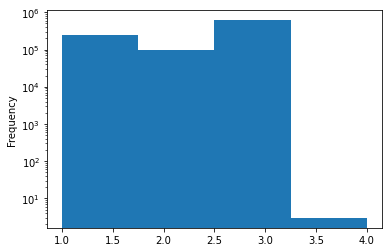

In [44]:
classification_counts['classification_count'].plot.hist(logy=True, bins=max(classification_counts['classification_count']))

# Plot sample of misclassified subjects

NEXT: Since subjects have been overclassified, we can't assume e.g. ones with three classifications received three _junk_ classifications. They might all be _real_, or any other combination. Need to discard all classifications after retirement.

In [51]:
misclassified_real_as_junk = cnn_scores[cnn_scores['zoo_classification_real'] & (cnn_scores['prediction'] > 0.5)]
misclassified_real_as_junk = misclassified_real_as_junk.merge(classification_counts)
misclassified_real_as_junk

,file,subject_id,prediction,zoo_classification_real,location,classification_count
0,1SWASPJ191851.17-181611.2_P1_fold.gif,23680962,1.000000,True,https://panoptes-uploads.zooniverse.org/subjec...,1
1,1SWASPJ193134.23-204007.3_P1_fold.gif,23727327,0.999987,True,https://panoptes-uploads.zooniverse.org/subjec...,1
2,1SWASPJ192637.84-191505.6_P3_fold.gif,23701332,0.658785,True,https://panoptes-uploads.zooniverse.org/subjec...,3
3,1SWASPJ193206.03+514729.8_P3_fold.gif,23732167,0.999991,True,https://panoptes-uploads.zooniverse.org/subjec...,1
4,1SWASPJ192819.14-101839.7_P3_fold.gif,23707606,0.990684,True,https://panoptes-uploads.zooniverse.org/subjec...,2
...,...,...,...,...,...,...
206807,1SWASPJ203444.63+063744.9_P1_fold.gif,24048083,0.995545,True,https://panoptes-uploads.zooniverse.org/subjec...,2
206808,1SWASPJ203054.11+052207.7_P1_fold.gif,24028608,0.980465,True,https://panoptes-uploads.zooniverse.org/subjec...,1
206809,1SWASPJ204039.25-495734.5_P1_fold.gif,24060619,0.999885,True,https://panoptes-uploads.zooniverse.org/subjec...,1
206810,1SWASPJ205254.57+014844.0_P1_fold.gif,24812174,0.863901,True,https://panoptes-uploads.zooniverse.org/subjec...,1


In [52]:
for classification_count in range(1, 4):
    print('Classification count: ', classification_count)
    for url in misclassified_real_as_junk[misclassified_real_as_junk['classification_count'] == classification_count].head(10)['location']:
        display(Image(url=url))

Classification count:  1


Classification count:  2


Classification count:  3
